# **Deep Learning Project - Pothole detection** <br/>
# **Xception Model**
**Data Science and Advanced Analytics with a specialization in Data Science**<br/>
**NOVA IMS**<br/>
Authors of this notebook:
*   Mafalda Paço - 20220619@novaims.unl.pt
*   Mª Margarida Graça - 20220602@novaims.unl.pt
*   Marta Dinis - 20220611@novaims.unl.pt
*   Nuno Dias - 20220603@novaims.unl.pt
*   Patrícia Morais - 20220638@novaims.unl.pt


## References
https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568

## Ready to use Dataset
https://drive.google.com/file/d/1KE507iE7Hwb7TiJINnvMYCXNIGrEgPvt/view?usp=share_link



## **Summary**
In this notebook, we applied Xception model that is capable of learning complex features.
It didn't show good results, since it returned worse values than of our previous models.

## **Data Import**

Necessary library imports.

In [ ]:
!pip install -q -U keras-tuner

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import time
import shutil
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.utils import plot_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 2.2 MB/s eta 0:00:00


Connection to the Data Source.

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/DL/Project/"
main_folder, training_folder, testing_folder = "DATA/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'DATA.zip', 'DATA.zip')
    # Extract files
    zip_ = zipfile.ZipFile('DATA.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 5.927 seconds


Definition of a list of parameters for the ``image_dataset_from_directory()`` function.


In [ ]:
image_size=(128, 128)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="binary"
validation_split=0.2
shuffle=True
seed=0

Loads the training data using the ``image_dataset_from_directory()``function and does an automatic split between training and validation data via validation_split, saving 20% for Validation.

In [ ]:
# Generate an object of type tf.data.Dataset
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder,
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split,
                                                shuffle=shuffle,
                                                seed=seed)

Found 1436 files belonging to 2 classes.
Using 1149 files for training.
Using 287 files for validation.


Loads the testing data using the ``image_dataset_from_directory()``function.

In [ ]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder,
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,
                                       shuffle=shuffle,
                                       seed=seed)

Found 16 files belonging to 2 classes.


## **Functions**

#### Plot function

In [ ]:
def plot_result_curves(fit_history, model_name):
  df_hist = pd.DataFrame.from_dict(fit_history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  secondary_y = ["accuracy", "val_accuracy", "AUROC", "val_AUROC"]
  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy",
                  xlabel="Epoch", title="Learning curves"+ " - " + model_name,
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"],
                         alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("Accuracy")
  ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
  ax.right_ax.set_ylim(0.45, 1.05)
  ax.legend(loc=(1.15, 0.40), framealpha=1.0)
  plt.show()

## **Xception Model**

The Xception model is known for its capability of learning complex features of the input images. This model uses depthwise separable convolutions, that instead of applying a single filter to the entire input tensor to produce a single output tensor, like in a standard convolution layer, performs the convolution separately across each channel of the input tensor, and then a 1x1 convolution is applied across all channels.
The Xception model is usually used on medical images but we decided to try to apply it, since our problem is also an image binary classification
Overall the Xception model is more efficient compared to traditional convolutional neural networks architectures and its relatively lightweight, which makes it easier to train.

<center><img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*VvBTMkVRus6bWOqrK1SlLQ.png" width=700></center>


We imported the Xception model, setting the 'weights' = None, so that we wouldn't be using weigths of the pretrained model (making it Transfer Learning) but rather train the whole model with our dataset. We also added more layers after the Xception base_model to control overfitting.

In [ ]:
base_model = Xception(include_top=False, weights=None, input_shape=(*image_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # L2 regularization
x = Dropout(0.2)(x)  # Dropout regularization
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)

Plot of the model into an image representation.

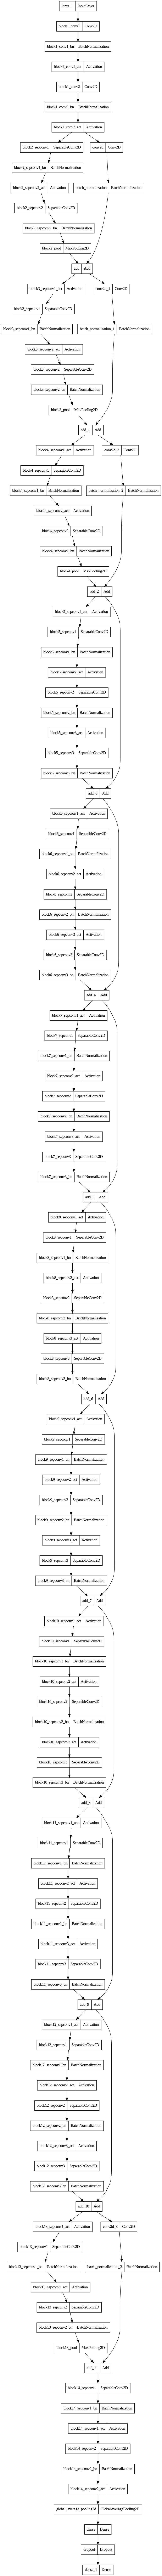

In [ ]:
plot_model(model, to_file='xception.png')

Compile and fit the model.

In [ ]:
train = True
if train:
    # Measure the start time
    start = time.time()

    learning_rate = 0.0001
    model.compile(loss="binary_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])

    epochs = 30
    history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed
    train = False

Epoch 1/30
18/18 [==============================] - 37s 525ms/step - loss: 1.5250 - accuracy: 0.4700 - AUROC: 0.4516 - val_loss: 1.5132 - val_accuracy: 0.5226 - val_AUROC: 0.5000
Epoch 2/30
18/18 [==============================] - 11s 473ms/step - loss: 1.5223 - accuracy: 0.4795 - AUROC: 0.4578 - val_loss: 1.5131 - val_accuracy: 0.5226 - val_AUROC: 0.5000
Epoch 3/30
18/18 [==============================] - 11s 488ms/step - loss: 1.5194 - accuracy: 0.4917 - AUROC: 0.4902 - val_loss: 1.5131 - val_accuracy: 0.5226 - val_AUROC: 0.5000
Epoch 4/30
18/18 [==============================] - 12s 481ms/step - loss: 1.5202 - accuracy: 0.4822 - AUROC: 0.4810 - val_loss: 1.5131 - val_accuracy: 0.5226 - val_AUROC: 0.5000
Epoch 5/30
18/18 [==============================] - 12s 510ms/step - loss: 1.5203 - accuracy: 0.4726 - AUROC: 0.4761 - val_loss: 1.5130 - val_accuracy: 0.5226 - val_AUROC: 0.5000
Epoch 6/30
18/18 [==============================] - 11s 464ms/step - loss: 1.5167 - accuracy: 0.4970 - AU

Plot the learning curves.

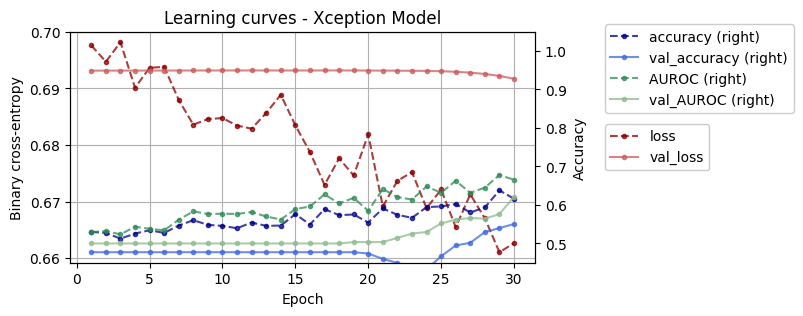

In [ ]:
# Plotting the results
plot_result_curves(history, "Xception Model")

This model didn't seem to work very well for our problem: the loss values barely decreased, the accuracy was very low when compared to our other models and there was quite a bit of overfitting.
Even though we have a small dataset, which lead to our decision of trying this model, we suspect it didn't perform well because our problem wasn't very complex.